# Face Recognition (Reconhecimento facial com LBPH)

## Importar bibliotecas

In [1]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import warnings

%matplotlib inline

# Filtrar warnings de erro
warnings.filterwarnings("ignore")

## Pré-processamento das imagens

In [2]:
# Detector de face com CNN
face_hog = dlib.cnn_face_detection_model_v1("modelo/mmod_human_face_detector.dat")

In [3]:
# Diretório que está localizado as imagens
path_images_train = os.path.join(os.getcwd(), "images", "Train")
path_images_test = os.path.join(os.getcwd(), "images", "Test")

In [4]:
# Função para percorrer todas as imagens da pasta, detectar as faces da imagem e retornar a imagem e os labels
def get_data_image(images_path):
    # Declarando lista com pixels das faces
    faces = []
    
    # Declarando lista com labels das faces
    labels = []
    
    # Percorrendo todas as pastas
    for name in os.listdir(images_path):
        path = os.path.join(images_path, name)
        label = name.replace(" ", "_")

        # Percorrendo todas as imagens da pasta
        for image in os.listdir(path):
            image_path = os.path.join(path, image)
            # Lendo imagem
            image = cv2.imread(image_path)
            # Mudando escala da imagem para cinza
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Detectando faces na imagem
            result_hog = face_hog(image_gray, 1)
            
            # Coletar pixels onde estão localizados a face e coletar somente a face da imagem
            for box in result_hog:
                startX = box.rect.left()
                startY = box.rect.top()
                endX = box.rect.right()
                endY = box.rect.bottom()

                startX = max(0, startX)
                startY = max(0, startY)
                endX = min(endX, image_gray.shape[1])
                endY = min(endY, image_gray.shape[0])
                
                w = endX - startX
                h = endY - startY
                
                faceROI = image_gray[startY:startY+h, startX:startX+w]   
                faceROI = cv2.resize(faceROI, (128, 128))
            
                # Inserindo pixels da imagem na lista de faces
                faces.append( faceROI )
                
                # Inserindo label da imagem na lista de labels
                labels.append(label)
                      
    return np.array(labels), faces

In [5]:
# Executar função para receber imagem e seus labels de treinamento
y_train, x_train = get_data_image(path_images_train)

In [6]:
# Treinar modelo de label encoder
le = LabelEncoder()
labels = le.fit(y_train)

In [7]:
# Executar função para receber imagem e seus labels de teste
y_test, x_test = get_data_image(path_images_test)

In [8]:
# Transformar labels das imagens em Ids
y_train = le.transform(y_train)
y_test = le.transform(y_test)

## Modelagem com Algoritmo LBPH

### Treinamento do modelo

In [9]:
# Instanciando modelo LBPH com seus hiperparametros
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(
    radius = 2,
    neighbors = 12,
    grid_x = 8,
    grid_y = 8
)

# Treinar modelo LBPH
lbph_classifier.train(x_train, y_train)

# Salvando modelo LBPH
lbph_classifier.write('lbph_classifier.yml')

### Avaliação do modelo (Imagens de teste)

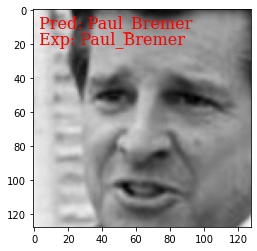

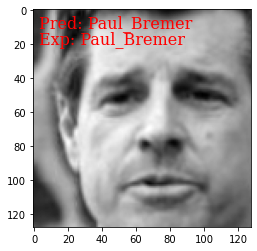

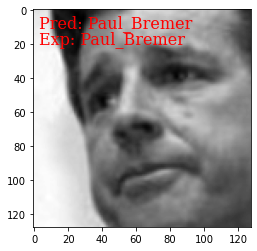

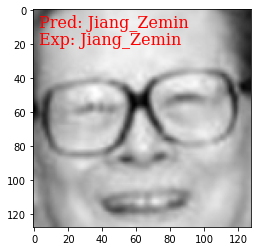

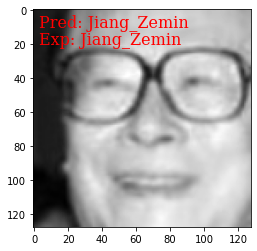

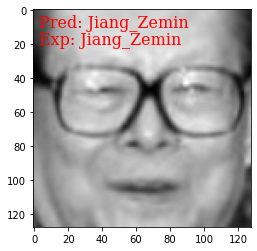

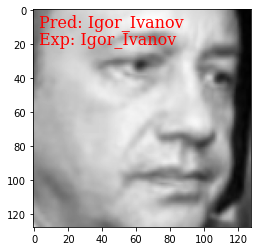

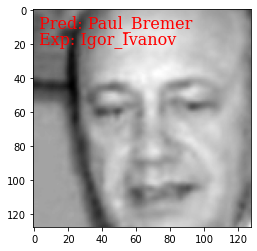

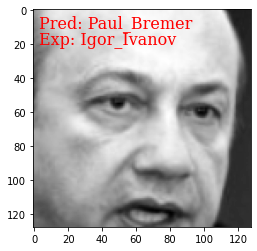

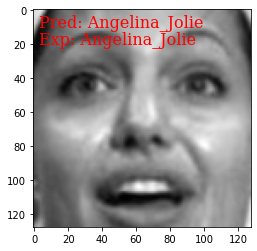

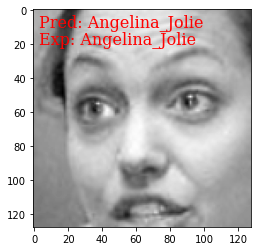

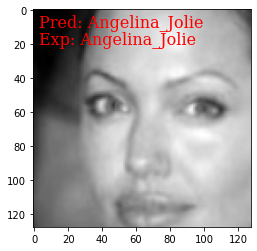

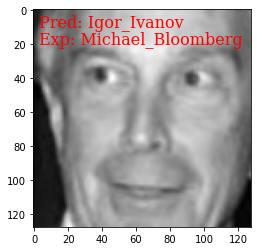

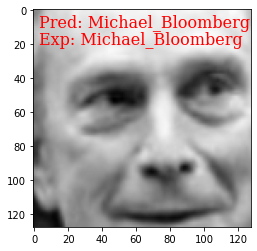

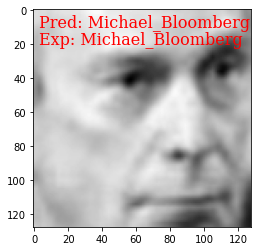

In [10]:
y_pred = []

for i in range(0, len(x_test)):
    predict, conf = lbph_classifier.predict(x_test[i])
    y_pred.append(predict)
    
    name_predict = le.inverse_transform([predict])
    name_exp = le.inverse_transform([y_test[i]])
    
    fig, ax = plt.subplots()
    ax.imshow(x_test[i], cmap="gray")
    ax.text(3, 10, "Pred: " + str(name_predict[0]), fontdict={
        'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        })
    ax.text(3, 20, "Exp: " + str(name_exp[0]), fontdict={
        'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        })
    fig.show()

In [11]:
# Relatório de avaliação
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.50      0.33      0.40         3
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.60      1.00      0.75         3

    accuracy                           0.80        15
   macro avg       0.82      0.80      0.79        15
weighted avg       0.82      0.80      0.79        15



## Fim